In [1]:
import os
import sys
import json
import datetime

import pandas as pd
import numpy as np

In [2]:
cwd = os.getcwd()
join = os.path.join
norm = os.path.normpath

In [3]:
sys.path.append(norm(join(cwd, '..', '..', '..', 'glhe')))

In [4]:
from standalone.plant_loop import PlantLoop
import glhe

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [15, 9]
plt.rcParams['font.size'] = 14

# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

In [7]:
data_path = norm(join(cwd, '..', '..', 'validation', 'MFRTRT', 'MFRTRT_loads.csv'))
df_raw_data = pd.read_csv(data_path, parse_dates=True, index_col='Date/Time')

In [31]:
df_sim_input_data = df_raw_data[['Inst. HT [1] [W]', 'mdot [kg/s]', 'Outlet 1 [C]', 'Inlet 1 [C]']].copy(deep=True)
df_sim_input_data.rename(columns = {'Inst. HT [1] [W]': 'Exp. HT Rate [W]', 
                                    'Outlet 1 [C]': 'Exp. Inlet [C]', 
                                    'Inlet 1 [C]': 'Exp. Outlet [C]'}, inplace=True)
df_sim_input_data.to_csv(join(cwd, 'input_data.csv'))

In [32]:
df_sim_input_data['time'] = pd.to_timedelta(df_sim_input_data.index)
df_sim_input_data['time'] = datetime.datetime(year=2019, month=1, day=1, hour=0, minute=0) + (df_sim_input_data['time'] - df_sim_input_data['time'][0])
df_sim_input_data.set_index('time', inplace=True)
df_sim_input_data.index.rename('Date/Time', inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Passing datetime64-dtype data to TimedeltaIndex is deprecated, will raise a TypeError in a future version
  """Entry point for launching an IPython kernel.


In [33]:
d = glhe.globals.functions.load_json('MFRTRT_STS_input.json')
d['ground-heat-exchanger'][0]['g-function-path'] = norm(join(cwd, '..', 'MFRTRT_EWT_g_functions', 'EWT_experimental_g_functions.csv'))
d['temperature-profile'][0]['path'] = norm(join(cwd, 'input_data.csv'))
d['flow-profile'][0]['path'] = norm(join(cwd, 'input_data.csv'))
d['simulation']['time-step'] = 5
d['simulation']['runtime'] = 3600 * 1

In [34]:
with open(join(cwd, 'in.json'), 'w') as f:
    f.write(json.dumps(d, sort_keys=True, indent=2, separators=(',', ': ')))

In [26]:
PlantLoop('in.json').simulate()

True

In [27]:
df = pd.read_csv('out.csv', index_col=0, parse_dates=True)

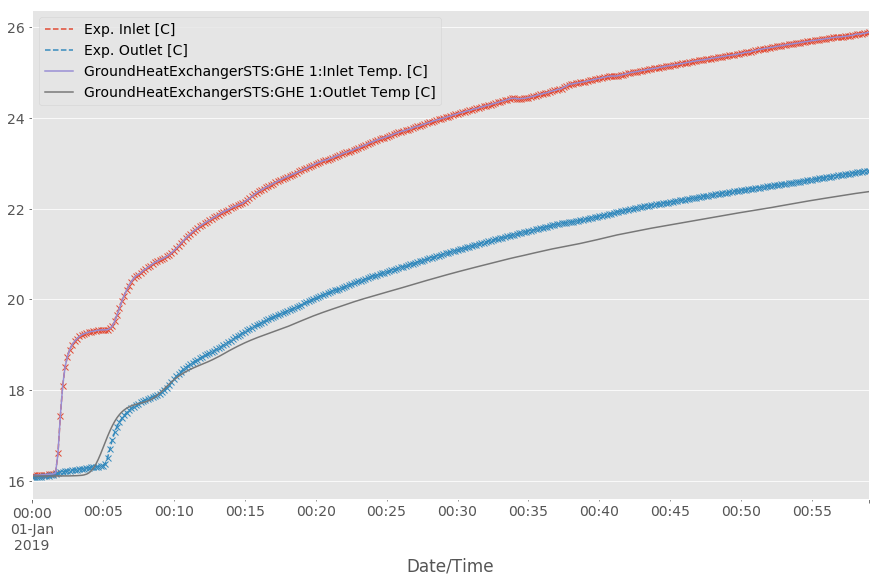

In [29]:
start_time = '2019-01-01 00:00:00'
end_time = '2019-01-01 00:59:00'

ax = df_sim_input_data[['Exp. Inlet [C]', 'Exp. Outlet [C]']].loc[start_time:end_time].plot(style='x--')
df[['GroundHeatExchangerSTS:GHE 1:Inlet Temp. [C]',
    'GroundHeatExchangerSTS:GHE 1:Outlet Temp [C]']].loc[start_time:end_time].plot(ax=ax)

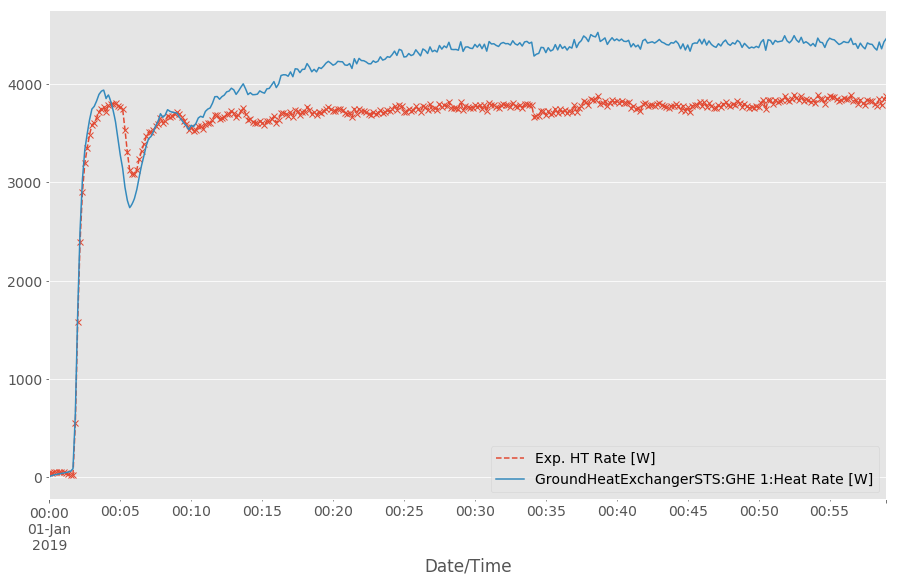

In [36]:
start_time = '2019-01-01 00:00:00'
end_time = '2019-01-01 00:59:00'

ax = df_sim_input_data[['Exp. HT Rate [W]']].loc[start_time:end_time].plot(style='x--')
df[['GroundHeatExchangerSTS:GHE 1:Heat Rate [W]']].loc[start_time:end_time].plot(ax=ax)

In [15]:
def plot_it(timestamp):
    t_in = []
    t_out = []
    depth = 76.2
    num_segs = 10
    dz = depth / num_segs
    d = np.arange(dz , depth + dz, dz)
    for i in range(10):
        val_in = df['SegmentUTubeBHGrouted:Seg No. {}:Inlet Temp Leg 1 [C]'.format(i+1)].loc[timestamp]
        val_out = df['SegmentUTubeBHGrouted:Seg No. {}:Outlet Temp Leg 1 [C]'.format(i+1)].loc[timestamp]
        t_in.append(val_in)
        t_out.append(val_out)

    plt.plot(t_in, d, label='Leg 1')
    plt.plot(t_out, d, label='Leg 2', linestyle='--')
    plt.ylim(80, 0)
    plt.ylabel('Depth [m]')
    plt.xlabel('Temperature [C]')
    plt.legend()

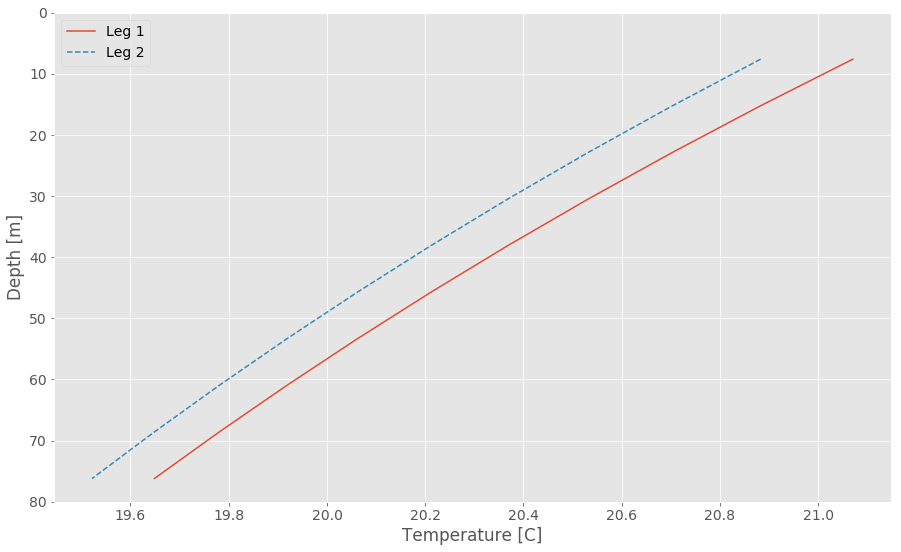

In [16]:
plot_it('2019-01-01 00:10:00')

In [17]:
Tg = 16.1
df['g'] = (df['GroundHeatExchangerSTS:GHE 1:Outlet Temp [C]'] - Tg) * 2 * 3.14159 * 2.7 / (4000 / 76.2)

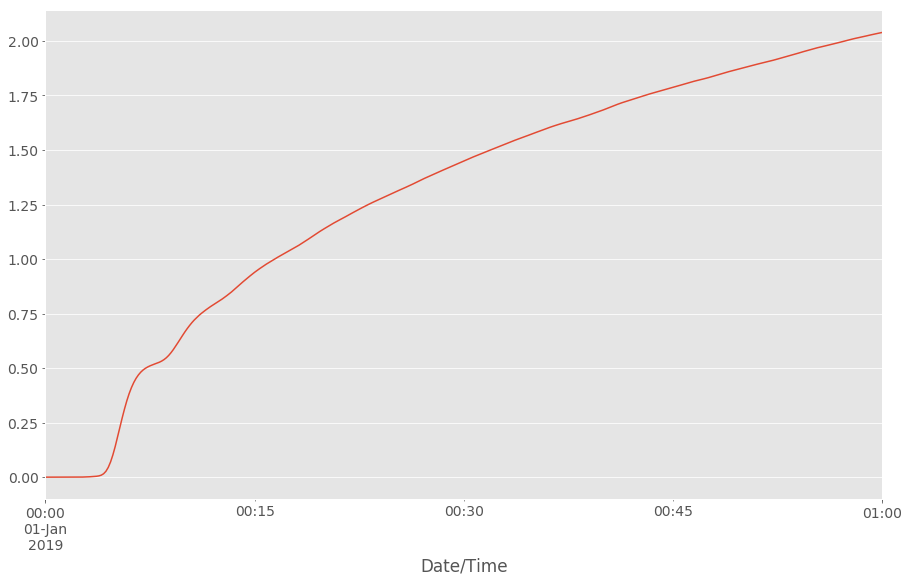

In [18]:
df['g'].plot()